Capstone Project: Prediksi Cuaca Sederhana Berbasis Data Historis dengan Machine Learning dan Visualisasi Web

**ID Team:** CC25-CR363

## 1. Import Library

In [15]:
pip install imbalanced-learn

In [16]:
!pip install keras-tuner

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import joblib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set(style="whitegrid")

## 2. Data Preparation

In [18]:
url = "https://raw.githubusercontent.com/melshitaardia/Weather-Prediction/main/weatherHistory.csv"
df = pd.read_csv(url)

df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in df.columns]

df['formatted_date'] = pd.to_datetime(df['formatted_date'], utc=True)
df['year'] = df['formatted_date'].dt.year
df['month'] = df['formatted_date'].dt.month
df['day'] = df['formatted_date'].dt.day
df['hour'] = df['formatted_date'].dt.hour

df['visibility_km'].fillna(df['visibility_km'].mean(), inplace=True)
df['pressure_millibars'].fillna(df['pressure_millibars'].mean(), inplace=True)
df['precip_type'].fillna(df['precip_type'].mode()[0], inplace=True)

<ipython-input-18-97f33cc6d858>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['visibility_km'].fillna(df['visibility_km'].mean(), inplace=True)
<ipython-input-18-97f33cc6d858>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

## 3. Data Preprocessing

### 3.1 Data Augmentation

In [19]:
def define_weather(row):
    summary = str(row['summary']).lower()
    precip = str(row['precip_type']).lower()
    if 'rain' in precip:
        return 'hujan'
    elif any(word in summary for word in ['cloud', 'overcast', 'fog']):
        return 'mendung'
    else:
        return 'cerah'

df['cuaca'] = df.apply(define_weather, axis=1)

### 3.2 Data Splitting

In [20]:
features = ['apparent_temperature_c', 'humidity', 'wind_bearing_degrees',
            'visibility_km', 'pressure_millibars', 'hour', 'month']

X = df[features]
y = df['cuaca']

# Balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y_res)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**teks tebal**## 4. EDA

### Sebelum SMOTE

Statistik deskriptif fitur numerik:
       apparent_temperature_c      humidity  wind_bearing_degrees  \
count            96453.000000  96453.000000          96453.000000   
mean                10.855029      0.734899            187.509232   
std                 10.696847      0.195473            107.383428   
min                -27.716667      0.000000              0.000000   
25%                  2.311111      0.600000            116.000000   
50%                 12.000000      0.780000            180.000000   
75%                 18.838889      0.890000            290.000000   
max                 39.344444      1.000000            359.000000   

       visibility_km  pressure_millibars          hour         month  \
count   96453.000000        96453.000000  96453.000000  96453.000000   
mean       10.347325         1003.235956     11.499891      6.523001   
std         4.192123          116.969906      6.922049      3.448501   
min         0.000000            0.000000      0.000000

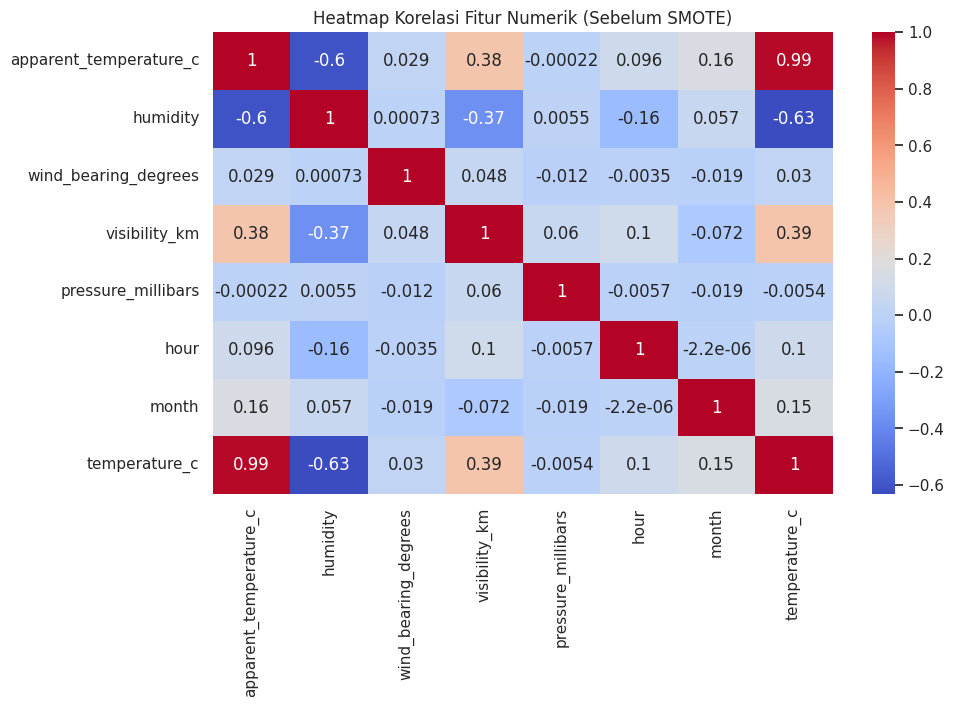

<ipython-input-21-4b8e4b63c0a6>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cuaca', data=df, palette='Set2')


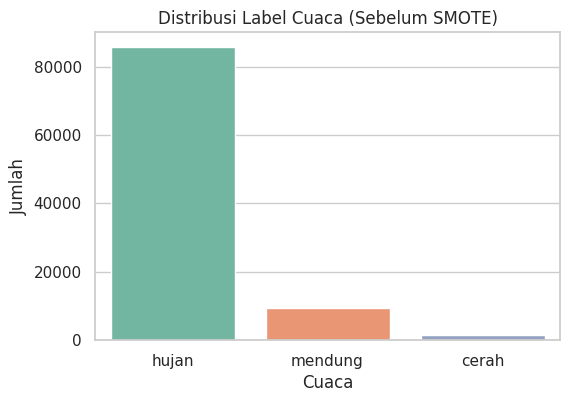

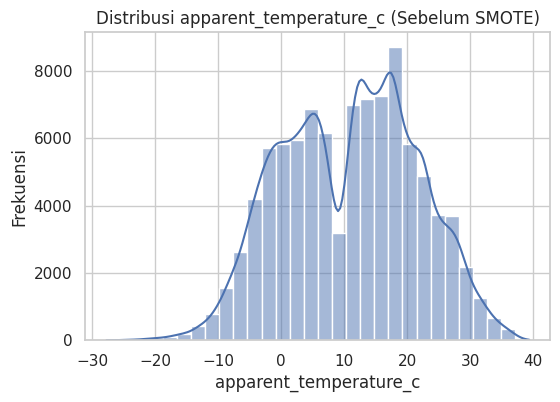

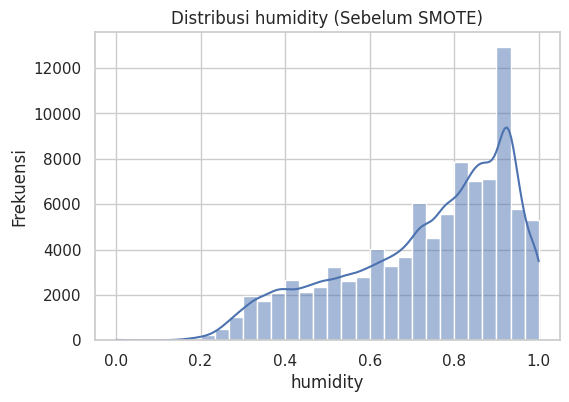

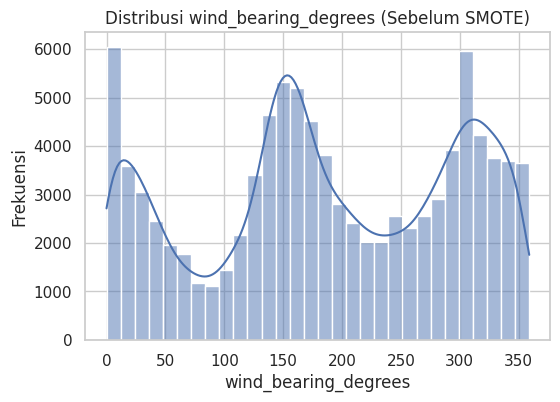

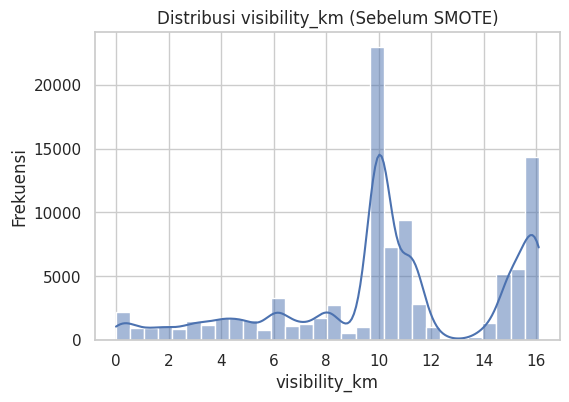

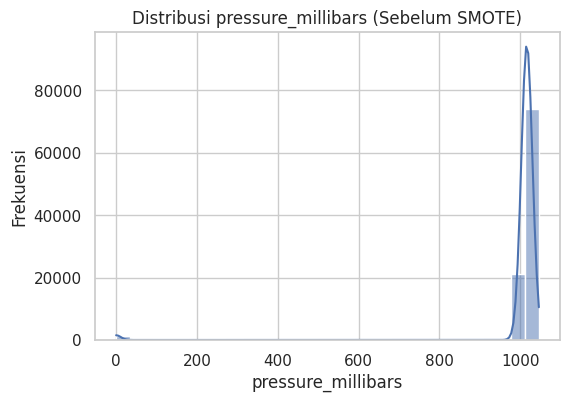

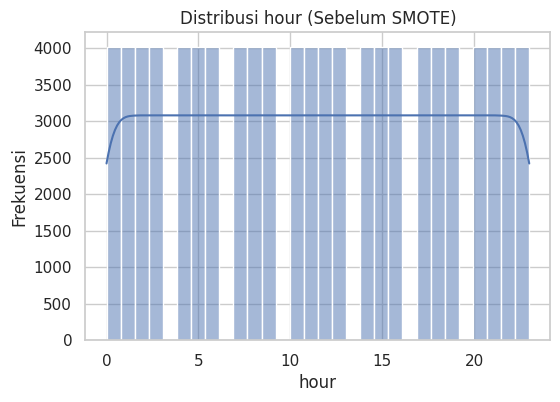

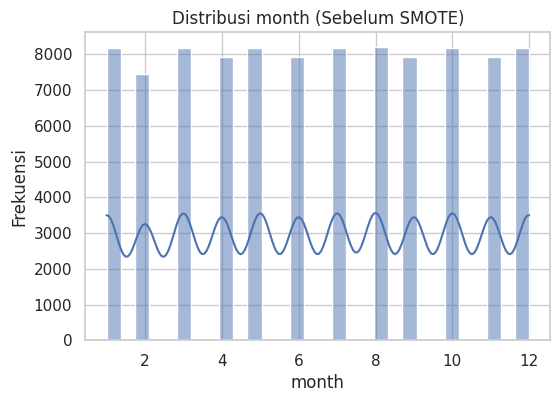

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


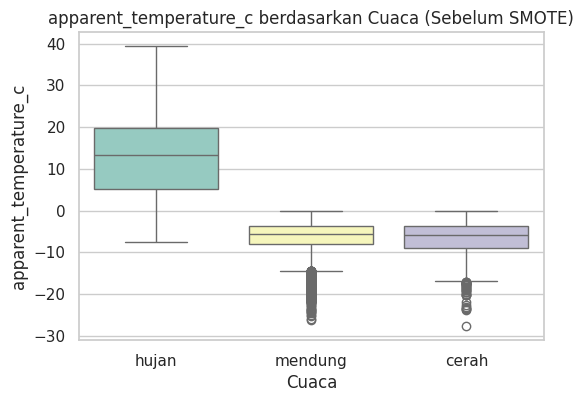

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


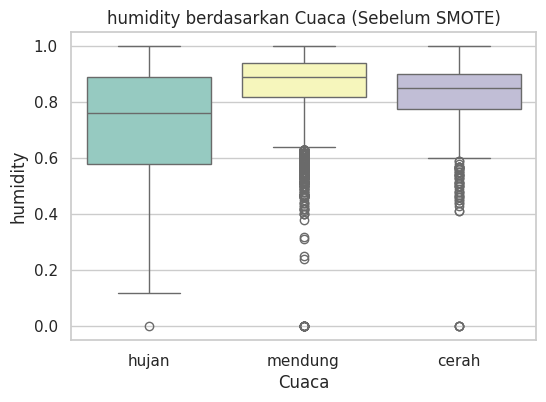

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


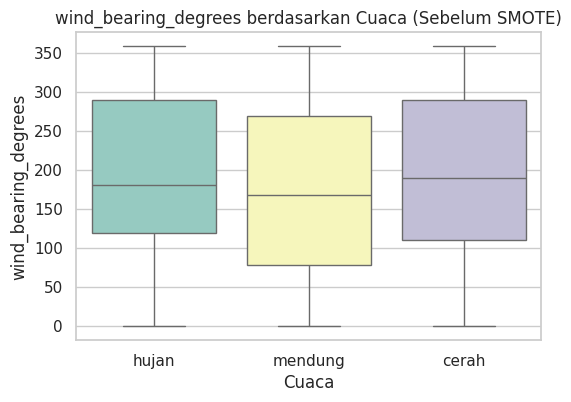

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


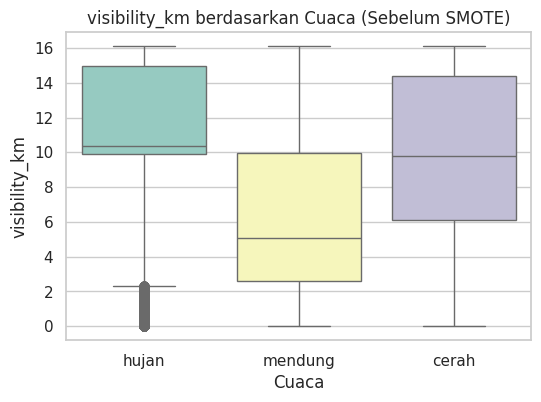

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


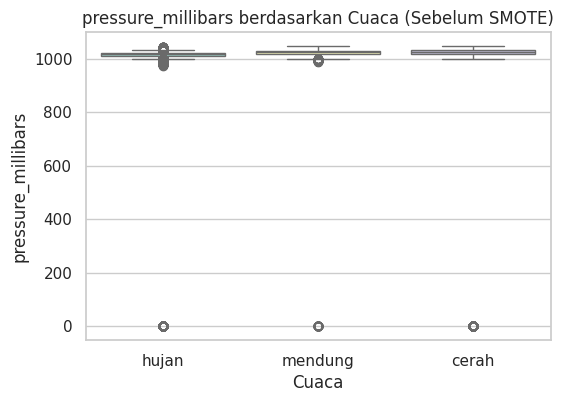

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


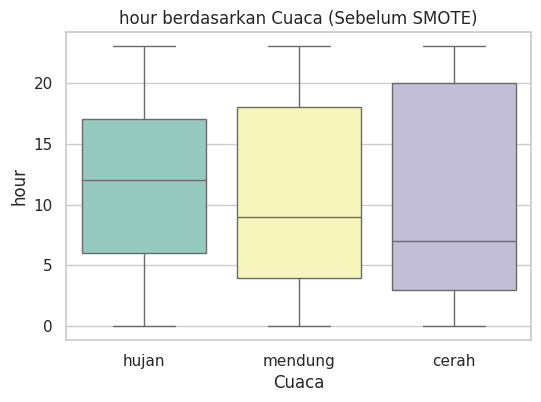

<ipython-input-21-4b8e4b63c0a6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')


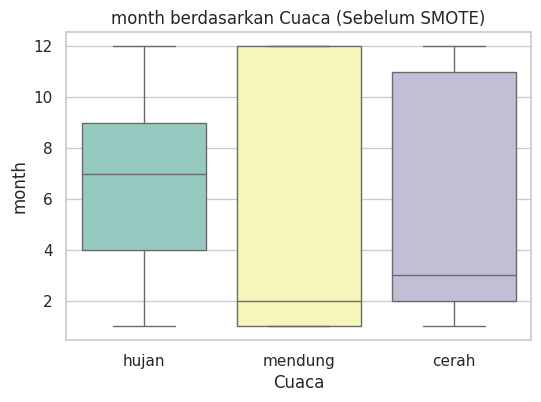

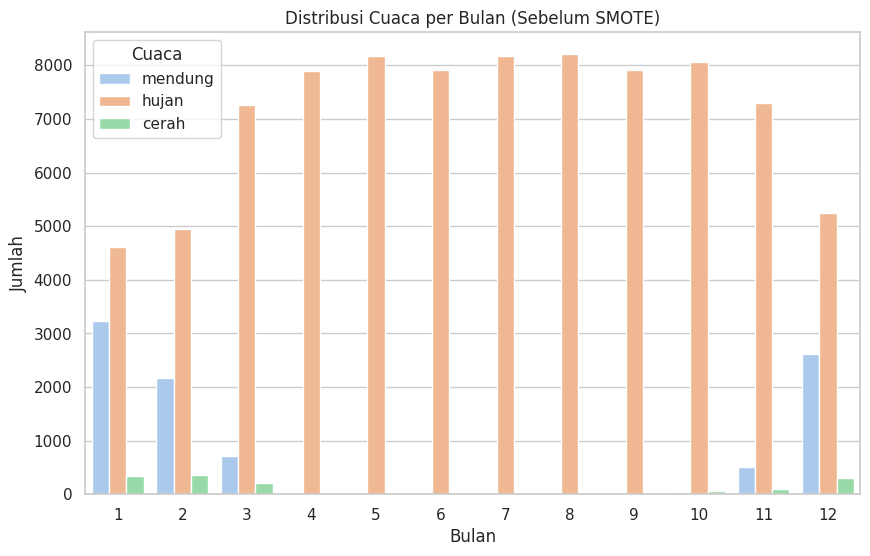

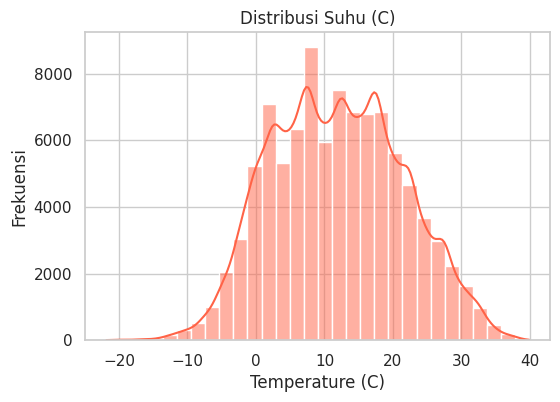

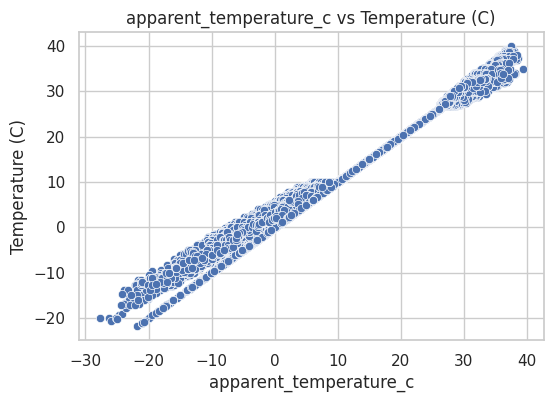

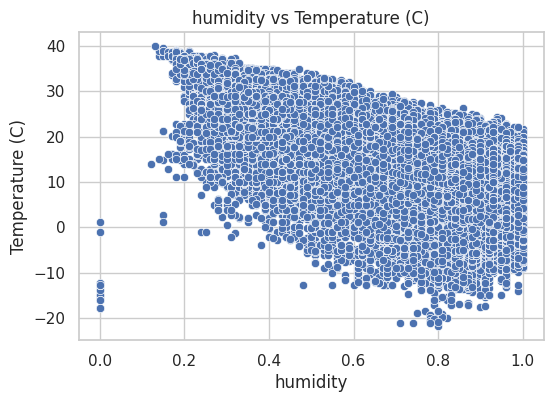

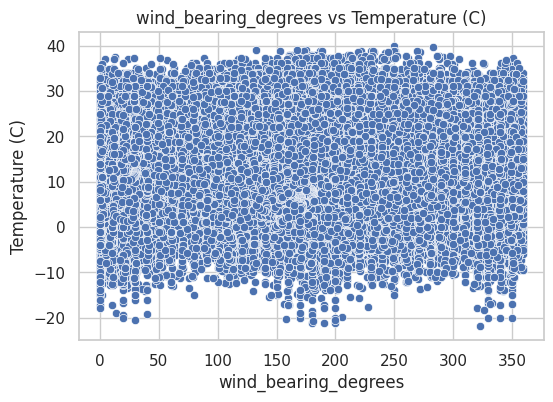

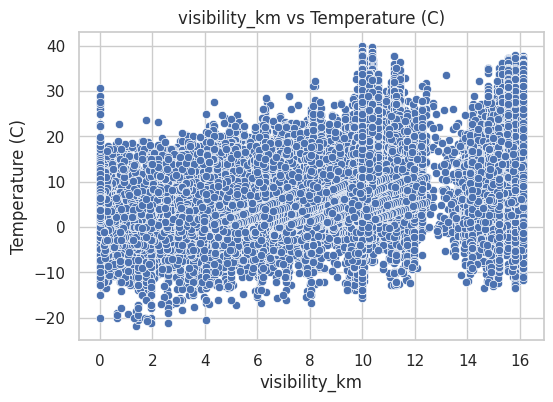

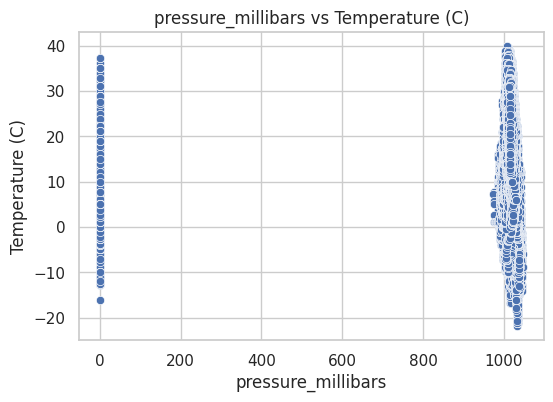

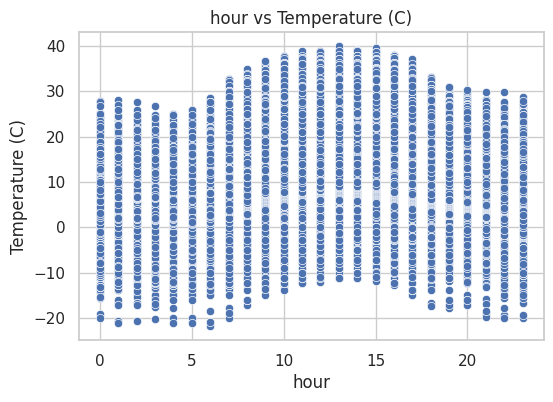

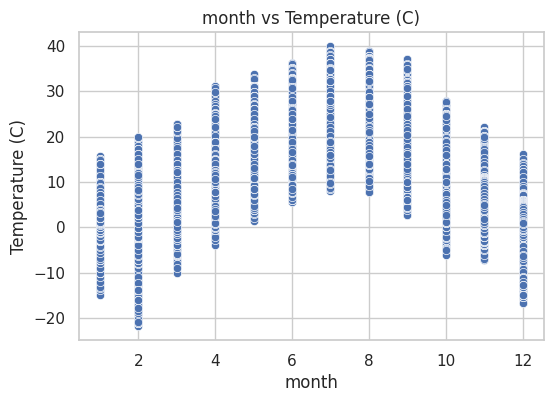

In [21]:
# Statistik Deskriptif Fitur Numerik
print("Statistik deskriptif fitur numerik:")
print(df[features + ['temperature_c']].describe())

# Korelasi Antar Variabel Numerik
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['temperature_c']].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur Numerik (Sebelum SMOTE)")
plt.show()

# Distribusi Label Target Klasifikasi: Cuaca
plt.figure(figsize=(6, 4))
sns.countplot(x='cuaca', data=df, palette='Set2')
plt.title("Distribusi Label Cuaca (Sebelum SMOTE)")
plt.xlabel("Cuaca")
plt.ylabel("Jumlah")
plt.show()

# Distribusi Masing-Masing Fitur Numerik
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribusi {col} (Sebelum SMOTE)')
    plt.xlabel(col)
    plt.ylabel("Frekuensi")
    plt.show()

# Boxplot Fitur terhadap Label Cuaca
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cuaca', y=col, data=df, palette='Set3')
    plt.title(f'{col} berdasarkan Cuaca (Sebelum SMOTE)')
    plt.xlabel("Cuaca")
    plt.ylabel(col)
    plt.show()

# Tren Distribusi Cuaca per Bulan
plt.figure(figsize=(10, 6))
sns.countplot(x='month', hue='cuaca', data=df, palette='pastel')
plt.title("Distribusi Cuaca per Bulan (Sebelum SMOTE)")
plt.xlabel("Bulan")
plt.ylabel("Jumlah")
plt.legend(title='Cuaca')
plt.show()

# Distribusi Target Regresi: Suhu
plt.figure(figsize=(6, 4))
sns.histplot(df['temperature_c'], kde=True, bins=30, color='tomato')
plt.title("Distribusi Suhu (C)")
plt.xlabel("Temperature (C)")
plt.ylabel("Frekuensi")
plt.show()

# Scatterplot Fitur vs Temperatur
for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y='temperature_c', data=df)
    plt.title(f'{col} vs Temperature (C)')
    plt.xlabel(col)
    plt.ylabel('Temperature (C)')
    plt.show()

### Setelah SMOTE

<ipython-input-22-b0040a39cbd9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cuaca', data=df_balanced, palette='Set2')


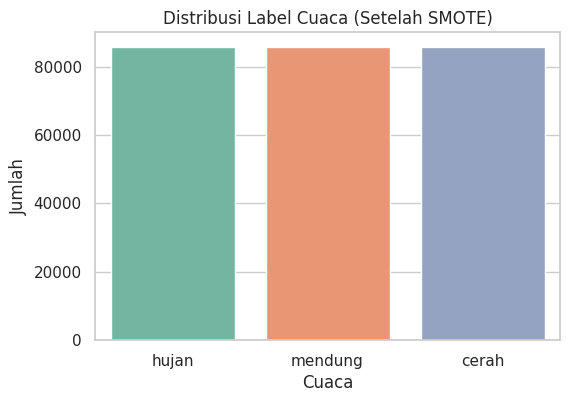

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


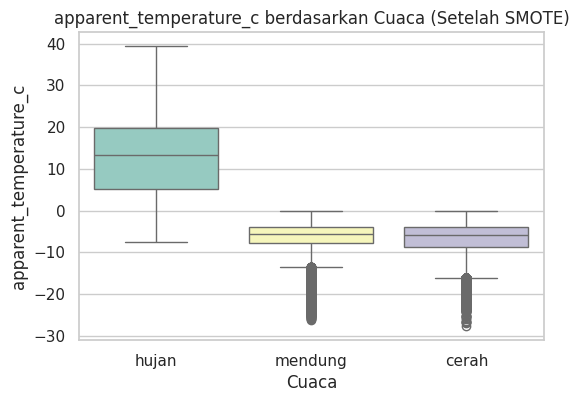

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


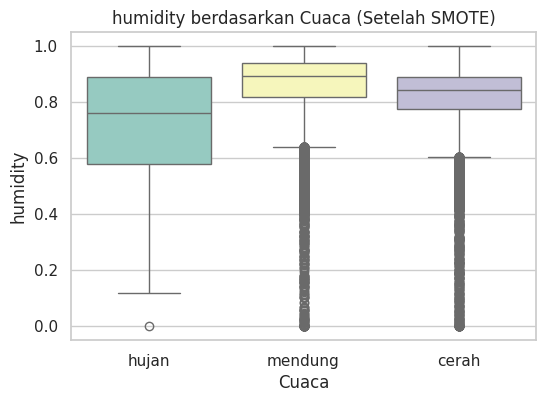

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


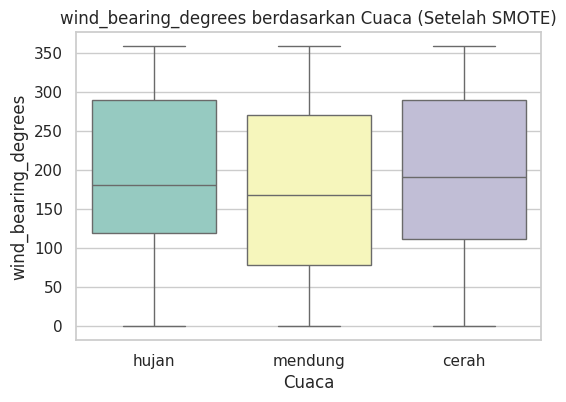

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


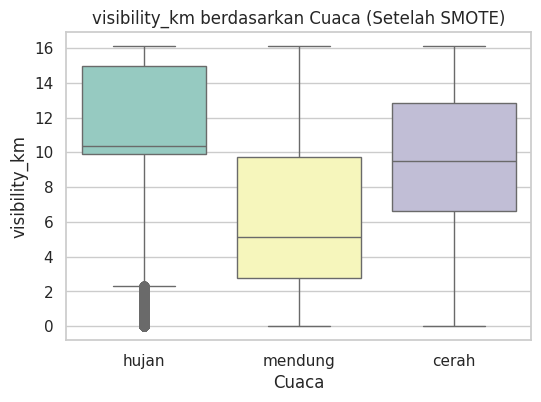

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


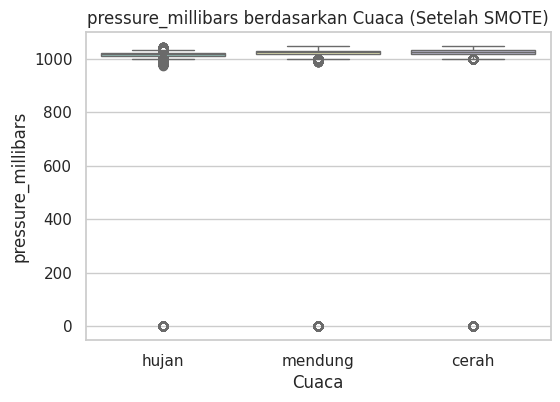

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


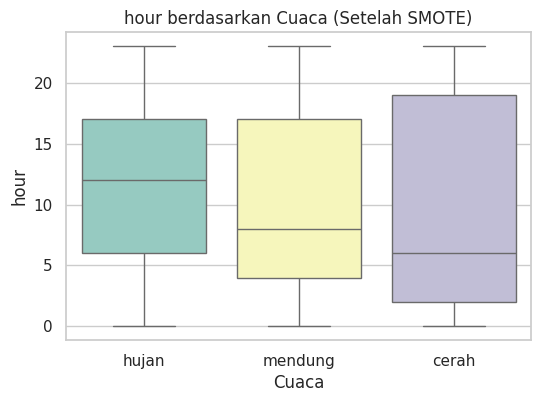

<ipython-input-22-b0040a39cbd9>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')


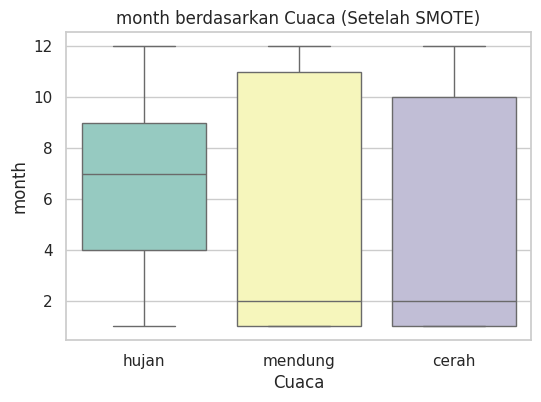

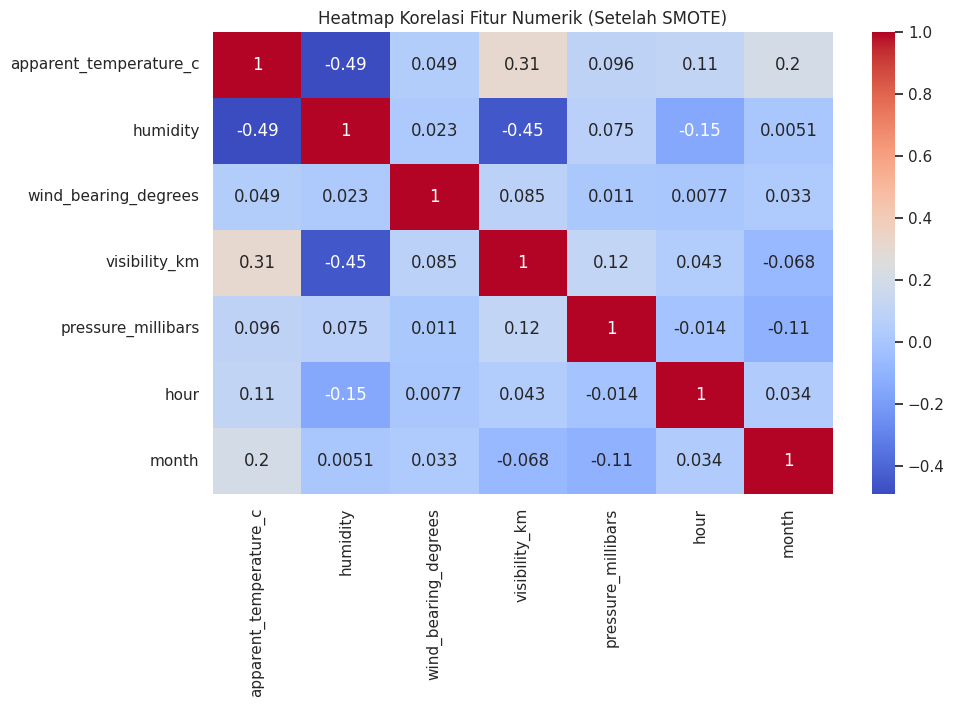

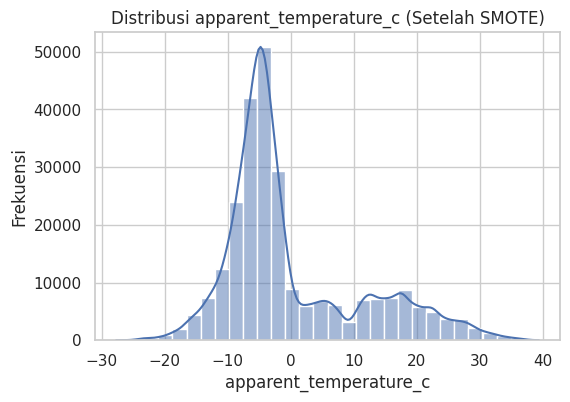

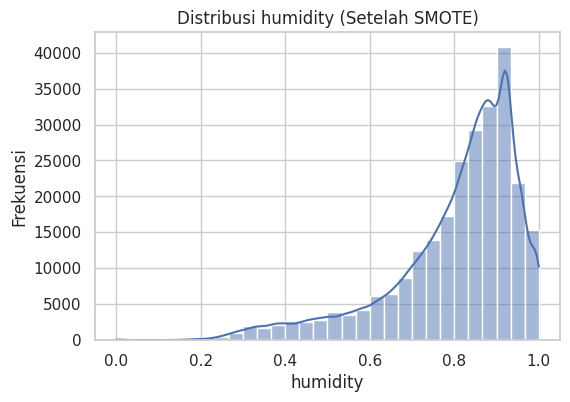

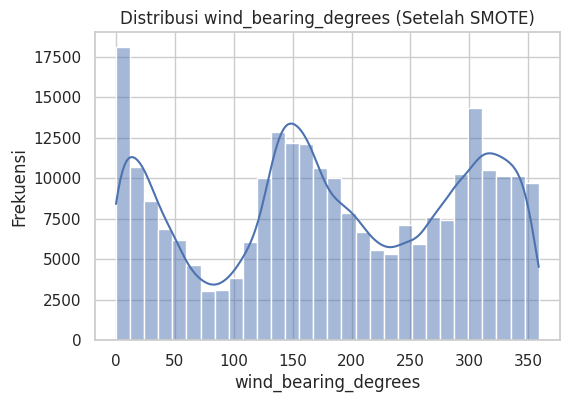

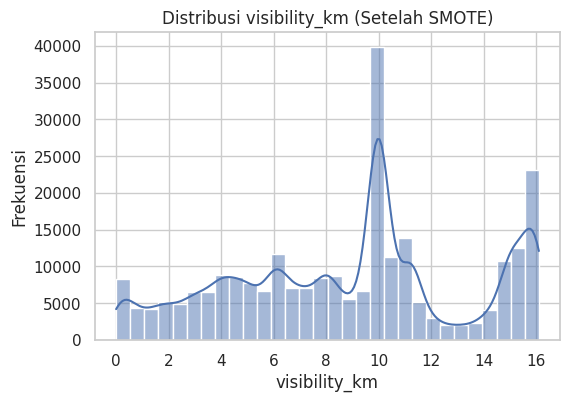

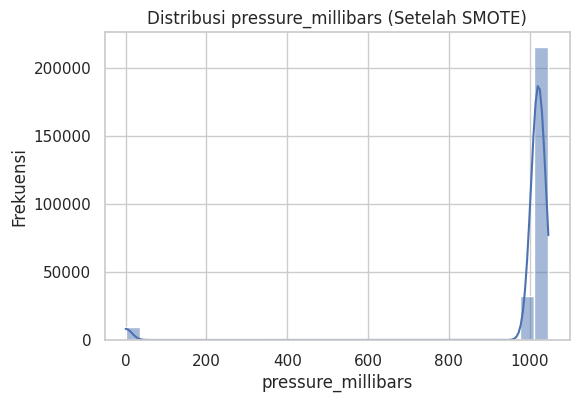

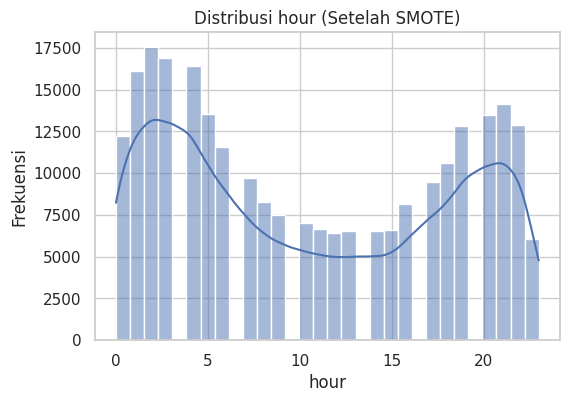

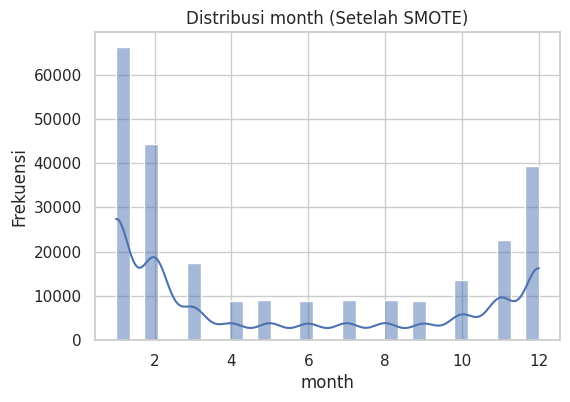


Statistik deskriptif fitur numerik (Setelah SMOTE):
       apparent_temperature_c       humidity  wind_bearing_degrees  \
count           257223.000000  257223.000000         257223.000000   
mean                 0.037272       0.803522            183.796260   
std                 11.043270       0.154544            109.076250   
min                -27.716667       0.000000              0.000000   
25%                 -6.807772       0.740000            105.000000   
50%                 -3.918092       0.848290            179.186626   
75%                  5.100000       0.914785            288.379112   
max                 39.344444       1.000000            359.000000   

       visibility_km  pressure_millibars           hour          month  
count  257223.000000       257223.000000  257223.000000  257223.000000  
mean        8.833391          984.658808      10.573813       5.495799  
std         4.507547          191.360980       7.486808       4.330850  
min         0.000000    

In [22]:
# Buat DataFrame dari data hasil SMOTE
df_balanced = pd.DataFrame(X_res, columns=features) # Menggunakan X_res
df_balanced['cuaca'] = y_res # Menggunakan y_res

# Distribusi Label Cuaca Setelah SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x='cuaca', data=df_balanced, palette='Set2')
plt.title("Distribusi Label Cuaca (Setelah SMOTE)")
plt.xlabel("Cuaca")
plt.ylabel("Jumlah")
plt.show()

# Boxplot Fitur terhadap Label Cuaca Setelah SMOTE
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cuaca', y=col, data=df_balanced, palette='Set3')
    plt.title(f'{col} berdasarkan Cuaca (Setelah SMOTE)')
    plt.xlabel("Cuaca")
    plt.ylabel(col)
    plt.show()

# Korelasi Antar Variabel Numerik Setelah SMOTE
plt.figure(figsize=(10, 6))
sns.heatmap(df_balanced[features].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur Numerik (Setelah SMOTE)")
plt.show()

# Distribusi Masing-Masing Fitur Setelah SMOTE
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_balanced[col], kde=True, bins=30)
    plt.title(f'Distribusi {col} (Setelah SMOTE)')
    plt.xlabel(col)
    plt.ylabel("Frekuensi")
    plt.show()

# Statistik Deskriptif Fitur Numerik Setelah SMOTE
# Ini membantu melihat apakah SMOTE mengubah rentang nilai fitur secara drastis
print("\nStatistik deskriptif fitur numerik (Setelah SMOTE):")
print(df_balanced[features].describe())

## 5. Modeling

In [23]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(), # n_neighbors default adalah 5
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss') # eval_metric untuk multiclass
}

model_performance = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\n--- Melatih Model: {model_name} ---")
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model

    # Prediksi pada data latih (untuk cek overfitting/underfitting)
    y_pred_train = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Prediksi pada data uji
    y_pred_test = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    model_performance[model_name] = {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "classification_report": classification_report(y_test, y_pred_test, target_names=le.classes_, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred_test)
    }
    print(f"Pelatihan {model_name} selesai.")
    print(f"Akurasi Latih {model_name}: {train_accuracy:.4f}")
    print(f"Akurasi Uji {model_name}: {test_accuracy:.4f}")


--- Melatih Model: Random Forest ---
Pelatihan Random Forest selesai.
Akurasi Latih Random Forest: 1.0000
Akurasi Uji Random Forest: 0.9841

--- Melatih Model: K-Nearest Neighbors ---
Pelatihan K-Nearest Neighbors selesai.
Akurasi Latih K-Nearest Neighbors: 0.9732
Akurasi Uji K-Nearest Neighbors: 0.9586

--- Melatih Model: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:10:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pelatihan XGBoost selesai.
Akurasi Latih XGBoost: 0.9626
Akurasi Uji XGBoost: 0.9512


## 6. Evaluation dan Visualization


--- Evaluasi dan Visualisasi Model ---

--- Hasil Evaluasi untuk Random Forest ---
Akurasi Latih: 1.0000
Akurasi Uji: 0.9841

Laporan Klasifikasi (Data Uji):
              precision    recall  f1-score   support

       cerah       0.98      1.00      0.99     17125
       hujan       1.00      0.97      0.98     17088
     mendung       0.97      0.99      0.98     17232

    accuracy                           0.98     51445
   macro avg       0.98      0.98      0.98     51445
weighted avg       0.98      0.98      0.98     51445



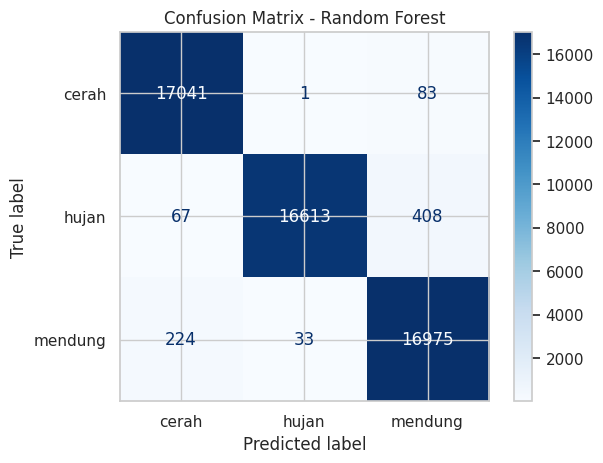

<ipython-input-24-33068ade8ee9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


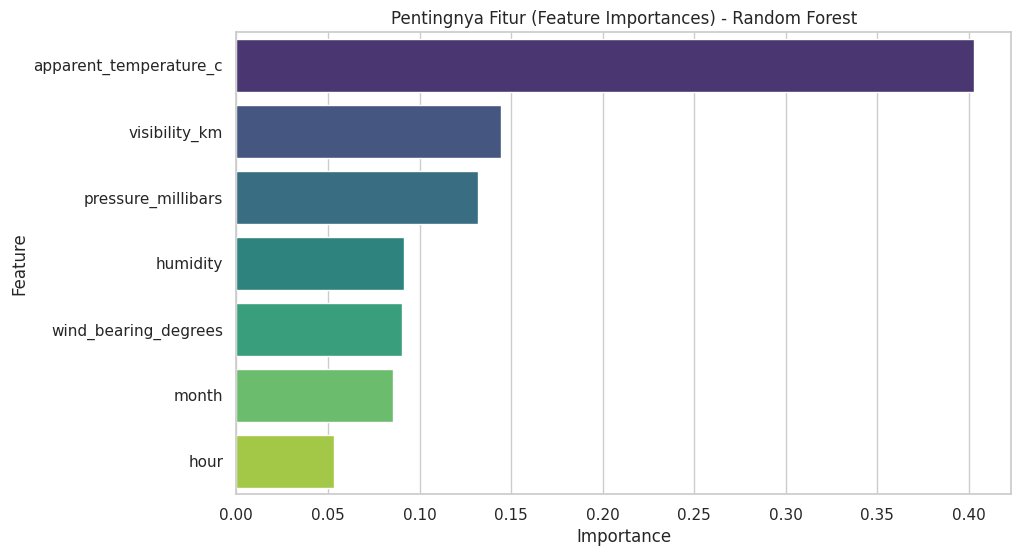


--- Hasil Evaluasi untuk K-Nearest Neighbors ---
Akurasi Latih: 0.9732
Akurasi Uji: 0.9586

Laporan Klasifikasi (Data Uji):
              precision    recall  f1-score   support

       cerah       0.93      0.99      0.96     17125
       hujan       1.00      0.94      0.97     17088
     mendung       0.95      0.94      0.95     17232

    accuracy                           0.96     51445
   macro avg       0.96      0.96      0.96     51445
weighted avg       0.96      0.96      0.96     51445



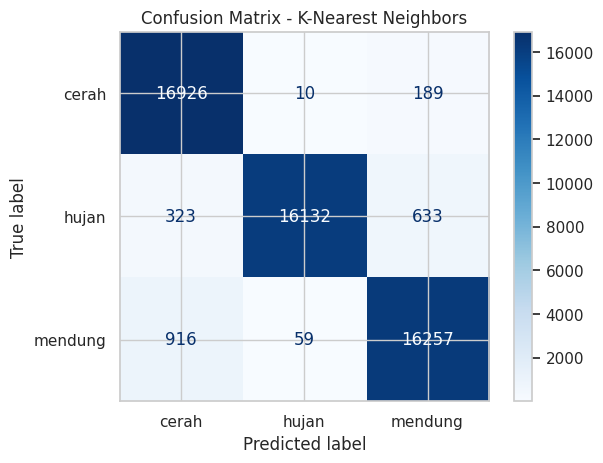


--- Hasil Evaluasi untuk XGBoost ---
Akurasi Latih: 0.9626
Akurasi Uji: 0.9512

Laporan Klasifikasi (Data Uji):
              precision    recall  f1-score   support

       cerah       0.92      0.96      0.94     17125
       hujan       0.99      0.97      0.98     17088
     mendung       0.94      0.92      0.93     17232

    accuracy                           0.95     51445
   macro avg       0.95      0.95      0.95     51445
weighted avg       0.95      0.95      0.95     51445



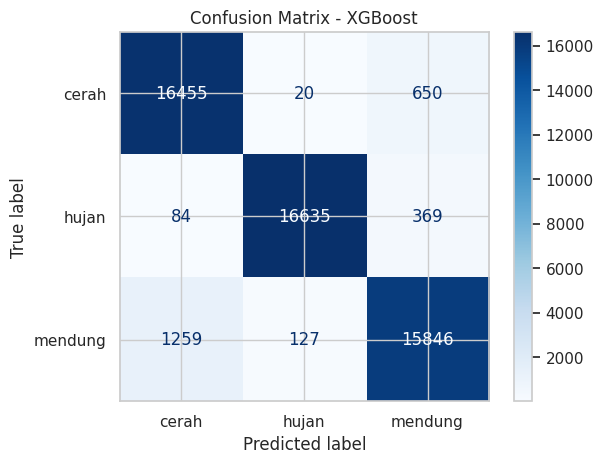

<ipython-input-24-33068ade8ee9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


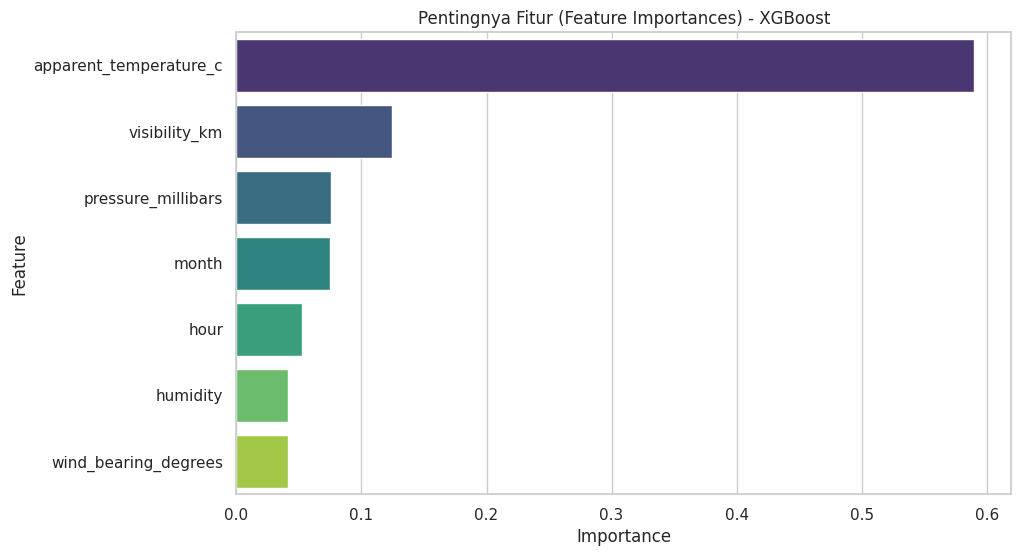

In [24]:
print("\n--- Evaluasi dan Visualisasi Model ---")
target_names_original = le.classes_

for model_name, performance in model_performance.items():
    print(f"\n--- Hasil Evaluasi untuk {model_name} ---")
    print(f"Akurasi Latih: {performance['train_accuracy']:.4f}")
    print(f"Akurasi Uji: {performance['test_accuracy']:.4f}")
    print("\nLaporan Klasifikasi (Data Uji):")
    print(classification_report(y_test, trained_models[model_name].predict(X_test_scaled), target_names=target_names_original))

    # Visualisasi Confusion Matrix
    cm = performance['confusion_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_original)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Visualisasi Feature Importances (jika ada, seperti Random Forest dan XGBoost)
    if hasattr(trained_models[model_name], 'feature_importances_'):
        importances = trained_models[model_name].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Pentingnya Fitur (Feature Importances) - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()


## 7. Menentukan Best Model

### 7.1 Bandingkan Performa Model




--- Perbandingan Performa Model (Akurasi Uji) ---
                 Model  Akurasi Latih  Akurasi Uji
0        Random Forest       1.000000     0.984138
1  K-Nearest Neighbors       0.973233     0.958597
2              XGBoost       0.962634     0.951229


<ipython-input-25-a033f88a5b18>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Akurasi Uji', y='Model', data=accuracies_df, palette='mako')


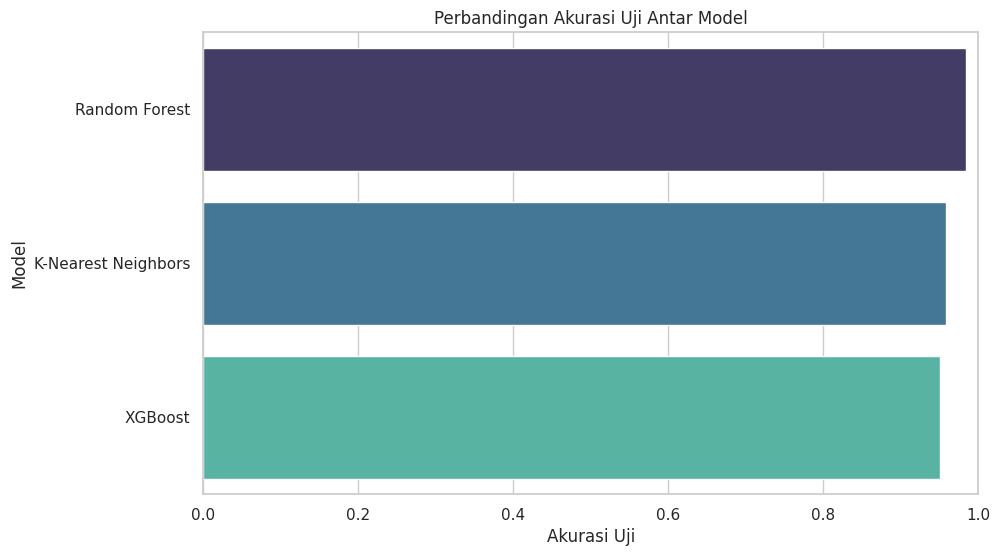

In [25]:
print("\n--- Perbandingan Performa Model (Akurasi Uji) ---")
accuracies_df = pd.DataFrame({
    'Model': list(model_performance.keys()),
    'Akurasi Latih': [perf['train_accuracy'] for perf in model_performance.values()],
    'Akurasi Uji': [perf['test_accuracy'] for perf in model_performance.values()]
}).sort_values(by='Akurasi Uji', ascending=False)
print(accuracies_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Akurasi Uji', y='Model', data=accuracies_df, palette='mako')
plt.title('Perbandingan Akurasi Uji Antar Model')
plt.xlabel('Akurasi Uji')
plt.ylabel('Model')
plt.xlim(0, 1.0)
plt.show()

### 7.2 Diagnosa Overfitting / Underfitting

In [26]:
print("\n--- Diagnosa Overfitting / Underfitting ---")
# Overfitting: Akurasi latih tinggi, akurasi uji jauh lebih rendah.
# Underfitting: Akurasi latih dan uji sama-sama rendah.
# Ideal: Akurasi latih dan uji tinggi dan tidak berbeda jauh.
for model_name, perf in model_performance.items():
    diff = perf['train_accuracy'] - perf['test_accuracy']
    print(f"{model_name}: Akurasi Latih={perf['train_accuracy']:.4f}, Akurasi Uji={perf['test_accuracy']:.4f}, Perbedaan={diff:.4f}")
    if diff > 0.1: # Threshold bisa disesuaikan
        print(f"  -> Potensi Overfitting pada {model_name}")
    elif perf['train_accuracy'] < 0.7 and perf['test_accuracy'] < 0.7: # Threshold bisa disesuaikan
         print(f"  -> Potensi Underfitting pada {model_name}")
    else:
        print(f"  -> Performa {model_name} terlihat cukup baik.")

# Pilih model terbaik berdasarkan akurasi uji tertinggi dan perbedaan latih-uji yang kecil
# Asumsikan Random Forest atau XGBoost seringkali menjadi kandidat baik
best_model_name = accuracies_df.iloc[0]['Model'] # Model dengan akurasi uji tertinggi
print(f"\nModel terbaik awal berdasarkan akurasi uji: {best_model_name}")


--- Diagnosa Overfitting / Underfitting ---
Random Forest: Akurasi Latih=1.0000, Akurasi Uji=0.9841, Perbedaan=0.0159
  -> Performa Random Forest terlihat cukup baik.
K-Nearest Neighbors: Akurasi Latih=0.9732, Akurasi Uji=0.9586, Perbedaan=0.0146
  -> Performa K-Nearest Neighbors terlihat cukup baik.
XGBoost: Akurasi Latih=0.9626, Akurasi Uji=0.9512, Perbedaan=0.0114
  -> Performa XGBoost terlihat cukup baik.

Model terbaik awal berdasarkan akurasi uji: Random Forest


### 7.3 Hyperparameter Tuning


--- Melakukan Hyperparameter Tuning untuk Random Forest ---
Memulai GridSearch CV untuk Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Parameter terbaik untuk Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Akurasi terbaik dari GridSearchCV: 0.9799103879437024

Akurasi Latih (Random Forest Tuned): 1.0000
Akurasi Uji (Random Forest Tuned): 0.9847

Laporan Klasifikasi (Random Forest Tuned - Data Uji):
              precision    recall  f1-score   support

       cerah       0.98      1.00      0.99     17125
       hujan       1.00      0.97      0.98     17088
     mendung       0.97      0.99      0.98     17232

    accuracy                           0.98     51445
   macro avg       0.98      0.98      0.98     51445
weighted avg       0.98      0.98      0.98     51445



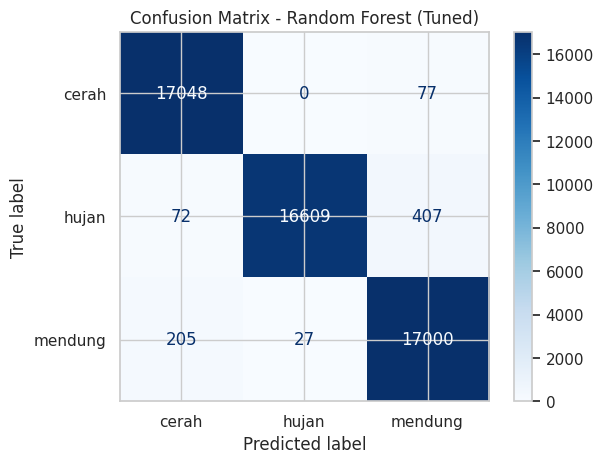


Model terbaik setelah tuning: Random Forest Tuned dengan akurasi uji 0.9847


In [27]:
if best_model_name == "Random Forest" or "Random Forest" in trained_models:
    print("\n--- Melakukan Hyperparameter Tuning untuk Random Forest ---")

    # Definisikan parameter grid
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Gunakan StratifiedKFold untuk menjaga distribusi kelas pada setiap fold
    cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # n_splits bisa disesuaikan

    # Inisialisasi GridSearchCV
    # Menggunakan n_jobs=-1 untuk menggunakan semua prosesor yang tersedia
    # verbose=2 untuk melihat proses tuning
    grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                                  param_grid=param_grid_rf,
                                  cv=cv_stratified,
                                  n_jobs=-1,
                                  verbose=2,
                                  scoring='accuracy') # Bisa ganti scoring lain

    # Lakukan fitting GridSearchCV
    print("Memulai GridSearch CV untuk Random Forest...")
    grid_search_rf.fit(X_train_scaled, y_train)

    print("\nParameter terbaik untuk Random Forest:", grid_search_rf.best_params_)
    print("Akurasi terbaik dari GridSearchCV:", grid_search_rf.best_score_)

    # Dapatkan model terbaik dari GridSearchCV
    best_rf_model = grid_search_rf.best_estimator_
    trained_models["Random Forest Tuned"] = best_rf_model # Simpan model yang sudah dituning

    # Evaluasi model yang sudah dituning
    y_pred_rf_tuned_train = best_rf_model.predict(X_train_scaled)
    train_accuracy_rf_tuned = accuracy_score(y_train, y_pred_rf_tuned_train)

    y_pred_rf_tuned_test = best_rf_model.predict(X_test_scaled)
    test_accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned_test)

    print(f"\nAkurasi Latih (Random Forest Tuned): {train_accuracy_rf_tuned:.4f}")
    print(f"Akurasi Uji (Random Forest Tuned): {test_accuracy_rf_tuned:.4f}")
    print("\nLaporan Klasifikasi (Random Forest Tuned - Data Uji):")
    print(classification_report(y_test, y_pred_rf_tuned_test, target_names=target_names_original))

    cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned_test)
    disp_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, display_labels=target_names_original)
    disp_rf_tuned.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Random Forest (Tuned)")
    plt.show()

    # Update best_model_name jika model yang dituning lebih baik
    # Ini adalah contoh sederhana, bisa dibuat lebih kompleks
    if "Random Forest Tuned" in trained_models:
        if test_accuracy_rf_tuned > model_performance.get(best_model_name, {}).get("test_accuracy", 0):
            best_model_name = "Random Forest Tuned"
            model_performance[best_model_name] = {
                "train_accuracy": train_accuracy_rf_tuned,
                "test_accuracy": test_accuracy_rf_tuned,
                "classification_report": classification_report(y_test, y_pred_rf_tuned_test, target_names=le.classes_, output_dict=True),
                "confusion_matrix": cm_rf_tuned
            }
            print(f"\nModel terbaik setelah tuning: {best_model_name} dengan akurasi uji {test_accuracy_rf_tuned:.4f}")


### 8. Konversi Model

In [28]:
final_best_model_name = best_model_name # Tentukan model terbaik final setelah semua evaluasi
final_best_model = trained_models[final_best_model_name]

print(f"\n--- Menyimpan Model Terbaik: {final_best_model_name} ---")
joblib.dump(final_best_model, f'{final_best_model_name.replace(" ", "_")}_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')
print(f"Model {final_best_model_name}, scaler, dan label encoder berhasil disimpan.")



--- Menyimpan Model Terbaik: Random Forest Tuned ---
Model Random Forest Tuned, scaler, dan label encoder berhasil disimpan.


## 9. Inference

In [29]:
print("\n--- Contoh Inference Menggunakan Model yang Disimpan ---")

# Muat model, scaler, dan label encoder
loaded_model = joblib.load(f'{final_best_model_name.replace(" ", "_")}_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')
loaded_le = joblib.load('label_encoder.joblib')
print("Model, scaler, dan label encoder berhasil dimuat.")

# Buat contoh data baru (harus memiliki fitur yang sama dengan data latih)
# apparent_temperature_c, humidity, wind_bearing_degrees, visibility_km, pressure_millibars, hour, month
contoh_data_baru = pd.DataFrame([
    [20.0, 0.8, 180, 10.0, 1012.0, 14, 7],  # Contoh cuaca cerah/mendung di sore hari bulan Juli
    [5.0, 0.95, 300, 2.0, 1005.0, 6, 12], # Contoh cuaca hujan/mendung di pagi hari bulan Desember
    [15.0, 0.6, 90, 15.0, 1015.0, 10, 3]   # Contoh cuaca cerah di pagi hari bulan Maret
], columns=features)

print("\nContoh data baru untuk inferensi:")
print(contoh_data_baru)

# Lakukan penskalaan pada data baru menggunakan scaler yang sudah di-fit
contoh_data_baru_scaled = loaded_scaler.transform(contoh_data_baru)

# Lakukan prediksi
prediksi_encoded = loaded_model.predict(contoh_data_baru_scaled)
prediksi_proba = loaded_model.predict_proba(contoh_data_baru_scaled) # Probabilitas untuk setiap kelas

# Ubah hasil prediksi dari encode menjadi label asli
prediksi_asli = loaded_le.inverse_transform(prediksi_encoded)

print("\nHasil Prediksi Cuaca:")
for i, pred in enumerate(prediksi_asli):
    print(f"Data ke-{i+1}: {pred}")
    # Tampilkan probabilitas jika diinginkan
    # print(f"  Probabilitas: {dict(zip(loaded_le.classes_, prediksi_proba[i]))}")


print("\n--- Analisis Selesai ---")
# Pastikan semua plot ditampilkan
plt.show()




--- Contoh Inference Menggunakan Model yang Disimpan ---
Model, scaler, dan label encoder berhasil dimuat.

Contoh data baru untuk inferensi:
   apparent_temperature_c  humidity  wind_bearing_degrees  visibility_km  \
0                    20.0      0.80                   180           10.0   
1                     5.0      0.95                   300            2.0   
2                    15.0      0.60                    90           15.0   

   pressure_millibars  hour  month  
0              1012.0    14      7  
1              1005.0     6     12  
2              1015.0    10      3  

Hasil Prediksi Cuaca:
Data ke-1: hujan
Data ke-2: hujan
Data ke-3: hujan

--- Analisis Selesai ---
